# Grocery Sales Demand Forecasting and Anomaly Detection

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, IsolationForest

# Load Dataset

In [40]:
df = pd.read_csv("grocery_chain_data.csv")
df.head()

,customer_id,store_name,transaction_date,aisle,product_name,quantity,unit_price,total_amount,discount_amount,final_amount,loyalty_points
0,2824,GreenGrocer Plaza,2023-08-26,Produce,Pasta,2.0,7.46,14.92,0.00,14.92,377
1,5506,ValuePlus Market,2024-02-13,Dairy,Cheese,1.0,1.85,1.85,3.41,-1.56,111
2,4657,ValuePlus Market,2023-11-23,Bakery,Onions,4.0,7.38,29.52,4.04,25.48,301
3,2679,SuperSave Central,2025-01-13,Snacks & Candy,Cereal,3.0,5.50,16.50,1.37,15.13,490
4,9935,GreenGrocer Plaza,2023-10-13,Canned Goods,Orange Juice,5.0,8.66,43.30,1.50,41.80,22


# Basic data cleaning


In [41]:
df.columns = df.columns.str.lower()

In [42]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       1980 non-null   int64         
 1   store_name        1955 non-null   object        
 2   transaction_date  1980 non-null   datetime64[ns]
 3   aisle             1980 non-null   object        
 4   product_name      1980 non-null   object        
 5   quantity          1980 non-null   float64       
 6   unit_price        1980 non-null   float64       
 7   total_amount      1980 non-null   float64       
 8   discount_amount   1980 non-null   float64       
 9   final_amount      1980 non-null   float64       
 10  loyalty_points    1980 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 170.3+ KB


# Create daily sales data


In [43]:
daily = (
    df.groupby("transaction_date")["final_amount"]
    .sum()
    .reset_index()
)

daily.columns = ["Date", "Sales"]
daily = daily.sort_values("Date")
daily.head()

,Date,Sales
0,2023-08-07,40.52
1,2023-08-08,228.57
2,2023-08-11,95.99
3,2023-08-12,129.94
4,2023-08-13,77.53


# Graph(Daily Grocery Sales)

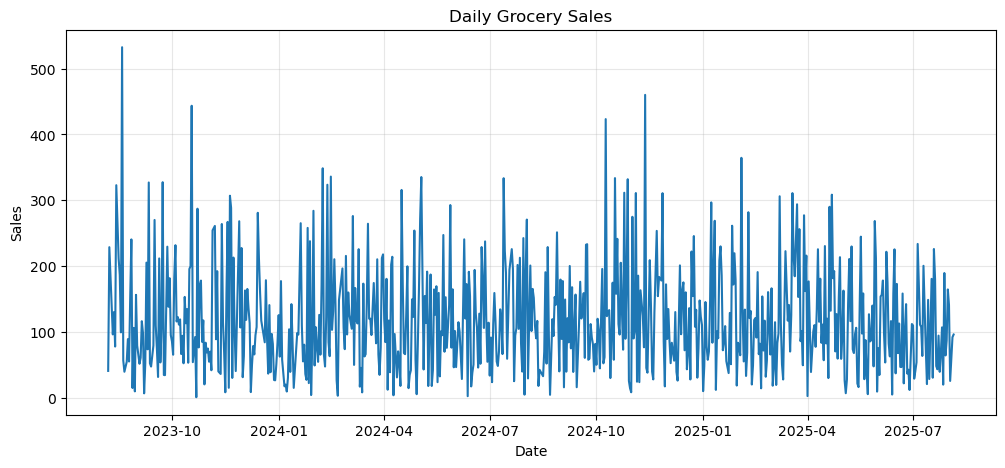

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(daily["Date"], daily["Sales"])
plt.title("Daily Grocery Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(alpha=0.3)
plt.show()

# Create features for the model


In [45]:
daily["day"] = daily["Date"].dt.day
daily["month"] = daily["Date"].dt.month
daily["weekday"] = daily["Date"].dt.weekday

daily.head()

,Date,Sales,day,month,weekday
0,2023-08-07,40.52,7,8,0
1,2023-08-08,228.57,8,8,1
2,2023-08-11,95.99,11,8,4
3,2023-08-12,129.94,12,8,5
4,2023-08-13,77.53,13,8,6


In [46]:
daily["lag_1"] = daily["Sales"].shift(1)
daily.dropna(inplace=True)

daily.head()

,Date,Sales,day,month,weekday,lag_1
1,2023-08-08,228.57,8,8,1,40.52
2,2023-08-11,95.99,11,8,4,228.57
3,2023-08-12,129.94,12,8,5,95.99
4,2023-08-13,77.53,13,8,6,129.94
5,2023-08-14,322.79,14,8,0,77.53


# Train Demand Forecasting Model

In [47]:
X = daily[["day", "month", "weekday", "lag_1"]]
y = daily["Sales"]

In [48]:
forecast_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

forecast_model.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Detect Anomalies

In [49]:
anomaly_model = IsolationForest(
    contamination=0.05,
    random_state=42
)

daily["anomaly"] = anomaly_model.fit_predict(daily[["Sales"]])
daily["anomaly"].value_counts()

anomaly
 1    653
-1     35
Name: count, dtype: int64

# Visualize sales trend and anomalies


In [50]:
daily["Sales_Smoothed"] = daily["Sales"].rolling(window=7).mean()

In [51]:
anomalies = daily[daily["anomaly"] == -1]
anomalies[["Date", "Sales"]].head()

,Date,Sales
5,2023-08-14,322.79
9,2023-08-19,532.52
30,2023-09-11,326.91
41,2023-09-23,327.35
65,2023-10-18,443.54


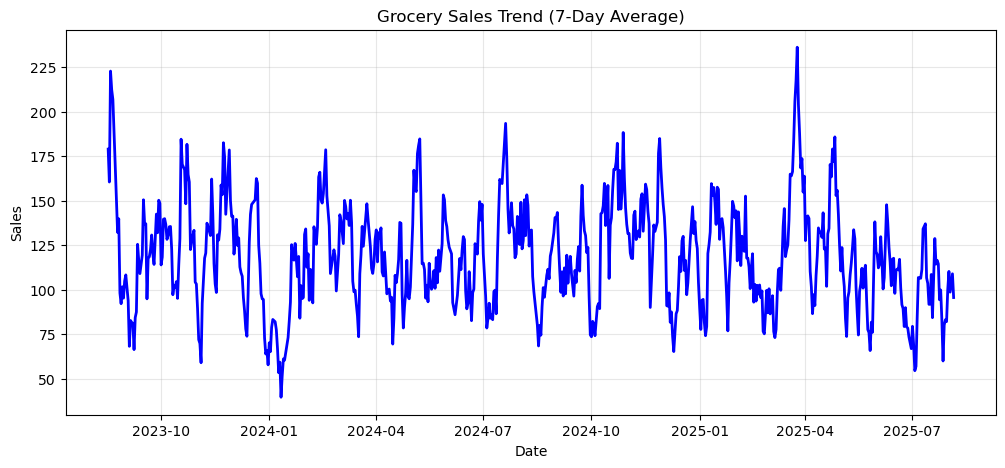

In [52]:
plt.figure(figsize=(12, 5))
plt.plot(
    daily["Date"],
    daily["Sales_Smoothed"],
    color="blue",
    linewidth=2
)
plt.title("Grocery Sales Trend (7-Day Average)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(alpha=0.3)
plt.show()

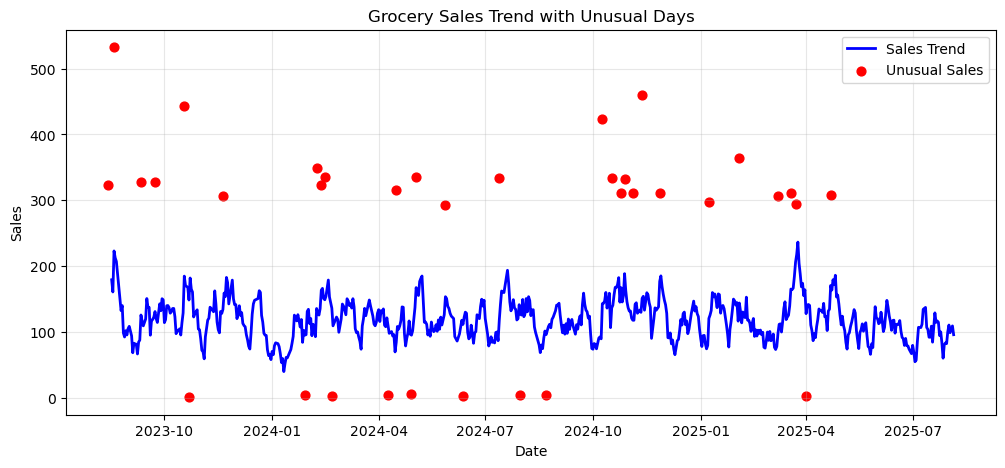

In [53]:
plt.figure(figsize=(12, 5))

# Sales trend
plt.plot(
    daily["Date"],
    daily["Sales_Smoothed"],
    color="blue",
    linewidth=2,
    label="Sales Trend"
)

# Anomalies
plt.scatter(
    anomalies["Date"],
    anomalies["Sales"],
    color="red",
    s=40,
    label="Unusual Sales"
)

plt.title("Grocery Sales Trend with Unusual Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#  Review detected anomalies


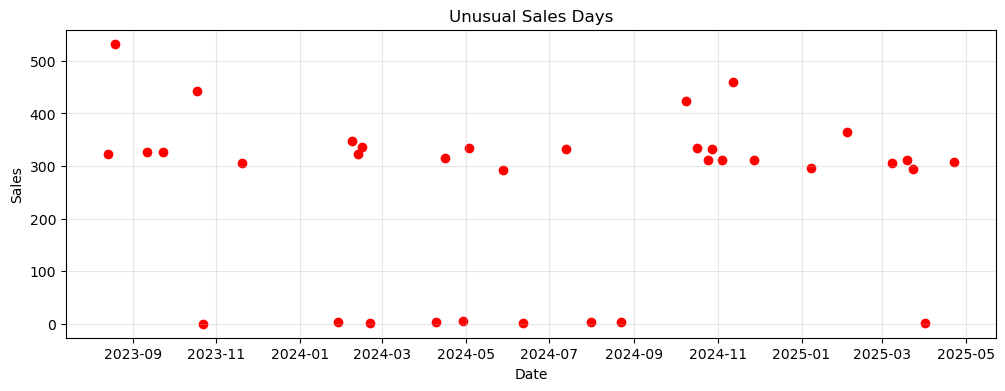

In [54]:
plt.figure(figsize=(12, 4))
plt.scatter(anomalies["Date"], anomalies["Sales"], color="red")
plt.title("Unusual Sales Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(alpha=0.3)
plt.show()

In [55]:
anomalies[["Date", "Sales"]]

,Date,Sales
5,2023-08-14,322.79
9,2023-08-19,532.52
30,2023-09-11,326.91
41,2023-09-23,327.35
65,2023-10-18,443.54
68,2023-10-22,0.51
95,2023-11-20,306.78
158,2024-01-29,3.81
168,2024-02-08,348.51
172,2024-02-12,323.48
